# Reformat Weather Underground Data
This is an example notebook to show how the data was generated. Due to data use agreements, the raw weather underground data is not provided -- but please contact me if you would like some help obtaining the Weather Underground data.

Note: depending on what time of day you are trying to analyze, you may want to alter this code as fit.

In [7]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt

from libpysal.weights import Rook

In [56]:
# Read a shape file
df = gpd.read_file('../preprocessed_data/charlotte_july_2023/census_tract.shp')
df = df.replace('-', np.nan)

# Read the WU data
wu_data = pd.read_csv('../data/raw/temperature/weather_underground/charlotte.csv')

wu_data = wu_data[wu_data['qcStatus'] == 1]
print(len(wu_data))
wu_data = wu_data[~wu_data['tempAvg'].isna()]
print(len(wu_data))

# Change obsTimeUtc to timestamp with UTC timezone
wu_data['obsTimeUtc'] = pd.to_datetime(wu_data['obsTimeUtc'])
# Change timezone to Eastern
wu_data['obsTimeUtc'] = wu_data['obsTimeUtc'].dt.tz_convert('US/Eastern')
wu_data.head()

278453
269076


,station,obsTimeUtc,qcStatus,solarRadiationHigh,uvHigh,winddirAvg,humidityHigh,humidityLow,humidityAvg,tempHigh,...,windspeedLow,windspeedAvg,windgustHigh,windgustLow,windgustAvg,pressureMax,pressureMin,pressureTrend,precipRate,precipTotal
0,KNCMATTH93,2023-07-01 00:59:47-04:00,1,0.0,0.0,179.0,92.0,90.0,90.7,23.8,...,0.0,0.0,0.0,0.0,0.0,1016.59,1015.58,-0.68,0.0,0.0
1,KNCMATTH93,2023-07-01 01:59:14-04:00,1,0.0,0.0,197.0,92.0,90.0,91.0,23.2,...,0.0,0.1,3.5,0.0,0.3,1016.26,1015.58,0.00,0.0,0.0
2,KNCMATTH93,2023-07-01 02:59:15-04:00,1,0.0,0.0,201.0,95.0,92.0,93.6,23.2,...,0.0,0.0,1.8,0.0,0.0,1016.26,1015.24,-0.69,0.0,0.0
3,KNCMATTH93,2023-07-01 03:59:15-04:00,1,0.0,0.0,201.0,97.0,95.0,96.2,22.8,...,0.0,0.0,0.0,0.0,0.0,1015.58,1014.90,0.00,0.0,0.0
4,KNCMATTH93,2023-07-01 04:59:14-04:00,1,0.0,0.0,201.0,98.0,97.0,97.3,22.3,...,0.0,0.0,0.0,0.0,0.0,1015.24,1014.90,0.00,0.0,0.0


If you only want to look at a specific time, use the cell below to filter accordingly.

In [58]:

# only keep data with 7pm observation time
# print(len(wu_data))
wu_data = wu_data[wu_data['obsTimeUtc'].dt.hour == 19]
# print(len(wu_data))

# # Filter so that minute > 30
# print(len(wu_data))
wu_data = wu_data[wu_data['obsTimeUtc'].dt.minute > 30]
# print(len(wu_data))

In [59]:
print(len(wu_data))
# Set index as stationId and obsTimeUtc
wu_data = wu_data.set_index(['station', 'obsTimeUtc'])

# Remove duplicates
wu_data = wu_data[~wu_data.index.duplicated(keep='first')]

print(len(wu_data))

wu_data.reset_index(inplace=True)

wu_data['date'] = wu_data['obsTimeUtc'].dt.date


11058
11058


In [60]:
# Change date to string -- select a specific day
wu_data['date'] = wu_data['date'].astype(str)
# wu_data = wu_data[wu_data['date'] == '2023-07-28']

In [29]:
# Obtain the minimum average temperature by stationId and date
# min_temp = wu_data.groupby(['stationId', 'date'])['tempAvg'].min().reset_index()
# Only keep if date has month of 5
# min_temp['date'] = pd.to_datetime(min_temp['date'])
# # min_temp = min_temp[min_temp['date'].dt.month == 9]
# min_temp

In [61]:
# pt = pd.pivot_table(wu_data, index='stationId', values='tempAvg', aggfunc=('count', 'mean'))
pt = pd.pivot_table(wu_data, index='station', values='tempAvg', aggfunc=('count', 'mean'))

In [62]:
# only keep stations with 31 observations
print(len(pt))
# pt = pt[pt['count'] > 29]
pt.reset_index(inplace=True)
print(len(pt))

385
385


In [63]:
# We obtain the lat/lon data for each station by reading from the list of stations
stations = pd.read_csv('../data/raw/temperature/weather_underground/charlotte_stations.csv')
stations = stations[stations['qc_status'] == 1]

In [64]:
print(len(pt))
pt = pt.merge(stations, left_on='station', right_on='station_id', how='inner')
pt.head()
print(len(pt))

385
385


In [65]:
mu = pt['mean'].mean()
std = pt['mean'].std()

# only keep values with mean less than 2 standard deviations above mean
pt = pt[pt['mean'] < mu + 2 * std]

This is the main piece of code that agreggates station data that falls within a census tract or census block group (depending on which shape file you are using).

In [66]:
geoid = []
income = []
population = []
num_stations = []
eve_avg = []
area = []
geometry = []


for i, row in df.iterrows():
    count = 0
    sum_temp = 0

    for j, s in pt.iterrows():
        # Check if station is in polygon
        p = Point(s['longitude'], s['latitude'])
        if row.geometry.contains(p):
            count += 1
            sum_temp += s['mean']


    geoid.append(row['geoid'])
    income.append(row['income'])
    population.append(row['population'])
    area.append(row['area'])
    geometry.append(row['geometry'])
    num_stations.append(count)

    if count == 0:
        eve_avg.append(np.nan)
    else:
        eve_avg.append(sum_temp/count)

assert len(geoid) == len(income) == len(population) == len(num_stations) == len(area) == len(geometry)

In [67]:
count_data = pd.DataFrame({
    "geoid": geoid,
    "income": income,
    "area": area,
    "population": population,
    "num_stations": num_stations,
    "tempAvg": eve_avg,
    "geometry": geometry
})

# Create a geopandas dataframe
count_data = gpd.GeoDataFrame(count_data, geometry='geometry')

<Axes: >

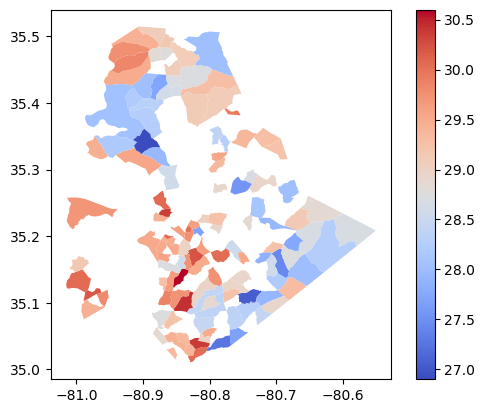

In [68]:
count_data.plot(column='tempAvg', legend=True, cmap='coolwarm')

In [55]:
print(count_data['num_stations'].sum())

# Save file for later use
# count_data.to_file('../preprocessed_data/charlotte_july_2023/census_tract.shp')

235
